In [42]:
import json

# Read the json in the path "C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_ingredientes_cultura.json"
with open(r"C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Otras_Bases\cbr_dataset_estructurado.json", 'r', encoding='utf-8') as f:
    data = json.load(f)

# Display the data
dict_tecnics = dict()
for case in data['menus']:
    for key in ["starter","main","dessert"]:
        for step in case['courses'][key]['structured_instructions']:
            action = step.get('preparation_action')
            if action:
                dict_tecnics[action] = dict_tecnics.get(action, 0) + 1
print("Numero de tecnicas:", len(dict_tecnics))
# Print all techniques sorted by value
for tecnic, count in sorted(dict_tecnics.items(), key=lambda item: item[1], reverse=True):
    print(f"{tecnic}: {count}")


Numero de tecnicas: 113
add: 41
remove: 17
place: 15
serve: 14
mix: 12
combine: 12
cook: 11
stir: 11
cut: 11
bake: 10
simmer: 9
heat: 9
bring: 8
chop: 7
let: 7
saut: 7
cover: 7
drain: 7
refrigerate: 7
preheat: 6
spread: 6
pour: 6
toss: 6
taste: 5
slice: 4
make: 4
drizzle: 4
set aside: 4
soak: 4
boil: 4
set: 4
cool: 4
transfer: 4
sprinkle: 4
allow: 3
peel: 3
reduce: 3
garnish: 3
fold: 3
pulse: 3
beat: 3
prepare: 3
spray: 2
roast: 2
blend: 2
line: 2
rinse: 2
lay: 2
brush: 2
spoon: 2
open: 2
reserve: 2
scoop: 2
shake: 2
puree: 2
squeeze: 2
score: 2
let sit: 2
dip: 2
whip: 2
seed: 1
flip: 1
turn off and let cool: 1
strain and pour: 1
get ready: 1
have: 1
re-heat: 1
divide: 1
top: 1
baste: 1
coat: 1
tear: 1
discard: 1
press: 1
let set: 1
crumble: 1
cut up: 1
mix in: 1
toss in: 1
dice: 1
core: 1
check: 1
let cool: 1
leave: 1
char: 1
keep: 1
gather: 1
warm: 1
turn: 1
test: 1
reduce heat: 1
season: 1
saute: 1
whisk: 1
grease: 1
invert: 1
take: 1
start: 1
roll: 1
store: 1
grease and flour: 1
ad

In [43]:
with open(r"C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_ingredientes_cultura.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
list_culturas = list(key for key in data["ontology_tree"].keys() if key not in ["Global/Common", "Unspecified"])
list_culturas = [cult.lower() for cult in list_culturas]
list_culturas

['latin american',
 'french/western european',
 'mediterranean',
 'south asian',
 'chinese',
 'american',
 'italian',
 'east asian',
 'japanese',
 'middle eastern/north african',
 'korean']

In [44]:
import json
import os
import time
import requests
import re
from time import sleep

# -------------------------------------------------
# CONFIGURATION
# -------------------------------------------------
OUTPUT_JSON = r'C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_cultura_tecnicas.json'
OUTPUT_JSON_SUBS = r'C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_tecnica_sustituciones.json'

HF_API_KEY = os.environ.get("HUGGINGFACE_API_KEY")
HF_MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
HF_CHAT_URL = "https://router.huggingface.co/v1/chat/completions"

HEADERS = {
    "Authorization": f"Bearer {HF_API_KEY}",
    "Content-Type": "application/json"
}

REQUEST_DELAY = 2  # seconds between API calls

# -------------------------------------------------
# UTILS
# -------------------------------------------------
def clean_llm_json(text):
    """Remove markdown and backticks from LLM response"""
    text = re.sub(r"^```json", "", text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"^```", "", text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"```$", "", text.strip(), flags=re.IGNORECASE)
    return text.strip()

def parse_llm_response(content):
    """Convert LLM response to JSON"""
    text = clean_llm_json(content)
    try:
        return json.loads(text)
    except Exception as e:
        return {"error": "json_parse_failed", "details": str(e), "raw": text}
def remap_json(input_json):
    """Values become keys, keys become values (list)"""
    output_json = dict()
    for key, values in input_json.items():
        for value in values:
            if value not in output_json:
                output_json[value] = []
            output_json[value].append(key)
    return output_json

# -------------------------------------------------
# PROMPTS
# -------------------------------------------------
def create_culture_tecnic_prompt(cultures_list, techniques_list):
    """Prompt for culture -> representative techniques (with optional extras)"""
    cultures_str = ", ".join(cultures_list)
    techniques_str = ", ".join(techniques_list)
    prompt = f"""
You are a culinary knowledge expert. Create a comprehensive knowledge base that maps cooking cultures to their representative cooking techniques.

Available cultures: {cultures_str}

Available techniques: {techniques_str}

For each tecnique:
- Consider if it is strongly associated with any of the listed cultures. If so, include it in the json with 
and list of cultures it belongs to, else omit it.
- A technique can belong to multiple cultures. At most, list 5 cultures per technique.
- Be consistent with culture names as provided in the available cultures list.
Rules:
- You can add extra techniques not in the available techniques list if they are strongly representative of a culture.
- MAKE SURE that each culture listed appears 
- Return ONLY a valid JSON object with this structure:
{{
  "Tecnique_name": ["culture1", "culture2", "culture3", ...],
  ...
}}

Do NOT include explanations, markdown, or additional text. Return ONLY the JSON object.
"""
    return prompt

def create_tecnic_substitution_prompt(techniques_list):
    """Prompt for technique -> substitute techniques"""
    techniques_str = ", ".join(techniques_list)
    prompt = f"""
You are a culinary expert. For each cooking technique, propose close substitutes from the provided list.

Available techniques: {techniques_str}

Rules:
- For each technique, return 3-6 alternative techniques that could replace it in a recipe.
- Use only techniques from the available list (no new ones).
- Do NOT include the original technique in its own substitution list.
- Favor substitutions that preserve texture/result as much as possible.

Return ONLY a valid JSON object with this structure:
{{
  "technique": ["substitute1", "substitute2", ...],
  ...
}}

Do NOT include explanations, markdown, or additional text. Return ONLY the JSON object.
"""
    return prompt

# -------------------------------------------------
# LLM CALL
# -------------------------------------------------
def generate_knowledge_base(prompt, output_path, max_retries=3):
    """
    Generic LLM call with retries and JSON save.
    """
    if not HF_API_KEY:
        return {"error": "HUGGINGFACE_API_KEY not set"}

    payload = {
        "model": HF_MODEL_NAME,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.3,
        "max_new_tokens": 2000
    }

    # Retry logic with exponential backoff
    for attempt in range(max_retries):
        try:
            print(f"  📡 Calling LLM (attempt {attempt + 1}/{max_retries})...", end="", flush=True)
            response = requests.post(HF_CHAT_URL, headers=HEADERS, json=payload, timeout=120)
            
            if response.status_code == 200:
                print(" ✓")
                result = response.json()
                content = result["choices"][0]["message"]["content"]
                kb = parse_llm_response(content)
                kb = remap_json(kb)
                
                # Save to JSON
                print(f"  💾 Saving to {output_path}")
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(kb, f, ensure_ascii=False, indent=2)
                
                print(f"  ✅ Saved successfully")
                return kb
                
            elif response.status_code in [502, 503, 504]:
                # Server errors - retry with backoff
                if attempt < max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f" ⚠️  HTTP {response.status_code}, retrying in {wait_time}s...")
                    sleep(wait_time)
                else:
                    print(f" ✗")
                    return {"error": f"HTTP {response.status_code}", "details": response.text[:500]}
            else:
                # Other errors
                print(f" ✗")
                return {"error": f"HTTP {response.status_code}", "details": response.text[:500]}
                
        except requests.Timeout:
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt
                print(f" ⚠️  Timeout, retrying in {wait_time}s...")
                sleep(wait_time)
            else:
                print(f" ✗")
                return {"error": "llm_call_failed", "details": "Request timeout after all retries"}
                
        except Exception as e:
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt
                print(f" ⚠️  Error ({str(e)[:50]}), retrying in {wait_time}s...")
                sleep(wait_time)
            else:
                print(f" ✗")
                return {"error": "llm_call_failed", "details": str(e)[:500]}

In [45]:
# Example usage
if HF_API_KEY:
    # Get cultures from the ontology
    culturas_lista = list_culturas
    
    # Get techniques from the first cell
    tecnicas_lista = sorted(dict_tecnics.keys())
    
    print(f"🔬 Creating culture-technique KB with {len(culturas_lista)} cultures and {len(tecnicas_lista)} techniques...")
    prompt_cult = create_culture_tecnic_prompt(culturas_lista, tecnicas_lista)
    kb_cult = generate_knowledge_base(prompt_cult, OUTPUT_JSON)

    if "error" not in kb_cult:
        print(f"\n✅ Culture-technique KB saved: {OUTPUT_JSON}")
        # Build technique set from the generated KB (deduplicated)
        all_tecnicas_from_kb = sorted({tech for techs in kb_cult.values() for tech in techs if isinstance(techs, list)})
        print(f"🔁 Creating technique-substitution KB for {len(all_tecnicas_from_kb)} techniques...")
        prompt_subs = create_tecnic_substitution_prompt(all_tecnicas_from_kb)
        kb_subs = generate_knowledge_base(prompt_subs, OUTPUT_JSON_SUBS)

        if "error" not in kb_subs:
            print(f"\n✅ Technique-substitution KB saved: {OUTPUT_JSON_SUBS}")
            print(f"   Total techniques with substitutes: {len(kb_subs)}")
        else:
            print(f"❌ Error generating substitutions: {kb_subs}")
    else:
        print(f"❌ Error generating culture-technique KB: {kb_cult}")
else:
    print("❌ HUGGINGFACE_API_KEY not set")

🔬 Creating culture-technique KB with 11 cultures and 113 techniques...
  📡 Calling LLM (attempt 1/3)... ✓
  💾 Saving to C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_cultura_tecnicas.json
  ✅ Saved successfully

✅ Culture-technique KB saved: C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_cultura_tecnicas.json
🔁 Creating technique-substitution KB for 124 techniques...
  📡 Calling LLM (attempt 1/3)... ✓
  💾 Saving to C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_tecnica_sustituciones.json
  ✅ Saved successfully

✅ Technique-substitution KB saved: C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Bases_Conocimientos\ontologia_tecnica_sustituciones.json
   Total techniques with substitutes: 118


In [46]:
# Read the json in the path OuTPUT_JSON_SUBS and OUTPUT_JSON and display them
with open(OUTPUT_JSON_SUBS, 'r', encoding='utf-8') as f:
    x = json.load(f)
data_sub = dict()
for key, value in x.items():
    data_sub[key] = set(value)
with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
    x = json.load(f)
data_cult = dict()
for key, value in x.items():
    data_cult[key] = set(value)

In [47]:
# Quiero crear una matriz de distancia entre culturas basado en las tecnicas de cocina que tiene uno pero no el otro.
culturas = list(data_cult.keys())
import numpy as np
dist_matrix = np.zeros((len(culturas), len(culturas)), dtype=int)
for i in range(len(culturas)):
    for j in range(i+1, len(culturas)):
        cult1 = culturas[i]
        cult2 = culturas[j]
        tecnicas_cult1 = data_cult[cult1]
        tecnicas_cult2 = data_cult[cult2]
        """common_tecnicas = tecnicas_cult1.intersection(tecnicas_cult2)
        if len(common_tecnicas) == min(len(tecnicas_cult1), len(tecnicas_cult2)):
            dist_matrix[i, j] = -1
            dist_matrix[j, i] = -1
            continue"""
        # Calcular la distancia como el numero de tecnicas que tiene cult1 pero no cult2
        dist = len(tecnicas_cult1 - tecnicas_cult2)
        dist_matrix[i, j] = dist
        # Callculamos el numero de tecnicas que tiene cult2 pero no cult1
        dist = len(tecnicas_cult2 - tecnicas_cult1)
        dist_matrix[j, i] = dist

# Display the distance matrix
import pandas as pd 
df_dist = pd.DataFrame(dist_matrix, index=culturas, columns=culturas)
df_dist
# Result explanation: The distance matrix shows the number of unique cooking techniques that one culture has compared to another. 
# For example, if df_dist.loc['Italian', 'French'] = 5, it means Italian cuisine has 5 cooking techniques that French cuisine does 
# not have. And df_dist.loc['French', 'Italian'] = 3 means French cuisine has 3 cooking techniques that Italian cuisine does not have.
    

,latin american,french/western european,mediterranean,south asian,american,italian,korean,middle eastern/north african,japanese,chinese,east asian
latin american,0,3,3,2,0,37,34,34,35,37,37
french/western european,86,0,0,0,0,34,120,120,120,120,120
mediterranean,86,0,0,0,0,34,120,120,120,120,120
south asian,87,2,2,0,1,36,120,121,121,121,121
american,86,3,3,2,0,37,120,120,121,123,123
italian,86,0,0,0,0,0,86,86,86,86,86
korean,1,4,4,2,1,4,0,1,1,3,3
middle eastern/north african,0,3,3,2,0,3,0,0,1,3,3
japanese,1,3,3,2,1,3,0,1,0,2,2
chinese,1,1,1,0,1,1,0,1,0,0,0


In [48]:
print("\nNumber of culture: ", len(data_cult))

for key, value in data_cult.items():
    print(f"{key}: {len(value)} techniques")


Number of culture:  11
latin american: 37 techniques
french/western european: 120 techniques
mediterranean: 120 techniques
south asian: 122 techniques
american: 123 techniques
italian: 86 techniques
korean: 4 techniques
middle eastern/north african: 3 techniques
japanese: 3 techniques
chinese: 1 techniques
east asian: 1 techniques


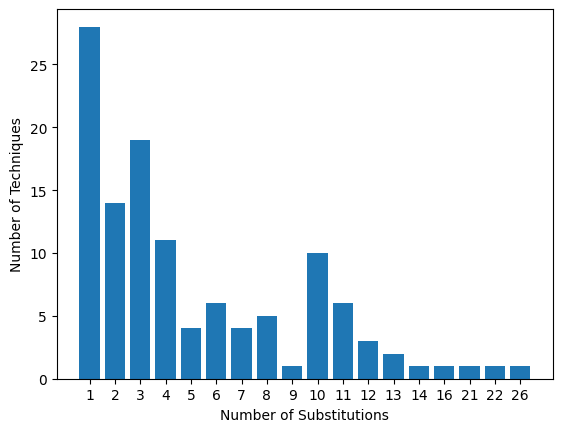

In [49]:
# Plot histogram of number of substitutions per technique
import matplotlib.pyplot as plt
num_substitutions =set(len(subs) for subs in data_sub.values())
num_substitutions = {str(num): 0 for num in sorted(num_substitutions)}

for subs in data_sub.values():
    num_substitutions[f'{len(subs)}'] += 1
plt.bar(num_substitutions.keys(), num_substitutions.values())
plt.xlabel('Number of Substitutions')
plt.ylabel('Number of Techniques')
plt.show()

In [50]:
case_base_path = r"C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Base_Casos\casos_cbr.json"
structured_case_base_path = r"C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Otras_Bases\cbr_dataset_estructurado.json"
import json
with open(case_base_path, 'r', encoding='utf-8') as f:
    case_base = json.load(f)
with open(structured_case_base_path, 'r', encoding='utf-8') as f:
    structured_case_base = json.load(f)

In [51]:
for i in range(10):
    for key in ["starter","main","dessert"]:
        if case_base['casos'][i]['solucion']['courses'][key]['recipe_id'] != structured_case_base['menus'][i]['courses'][key]['recipe_id']:
            print(f"Mismatch in case {i} course {key}")
            continue
        case_base['casos'][i]['solucion']['courses'][key]['structured_instructions'] = structured_case_base['menus'][i]['courses'][key]['structured_instructions']

In [52]:
#save the modified case base to a new json file
modified_case_base_path = r"C:\Users\jiaha\Documents\Universidad\SBC\SBC-MENU\PART2\Base_Casos\casos_cbr.json"
with open(modified_case_base_path, 'w', encoding='utf-8') as f:
    json.dump(case_base, f, ensure_ascii=False, indent=2)


    

In [53]:
structured_case_base['menus'][8]['courses']['dessert']

{'recipe_id': 641600,
 'title': 'Double Chocolate Mousse Squares (Rigo Jancsi)',
 'servings': 6,
 'price_per_serving': 309.87,
 'ready_in_minutes': 0,
 'ingredients': ['glaze',
  'bitter chocolate',
  'bittersweet chocolate',
  'butter',
  'cake flour',
  'cinnamon',
  'cocoa powder',
  "confectioners' sugar",
  'corn syrup',
  'eggs',
  'espresso powder',
  'granulated sugar',
  'heavy cream',
  'salt',
  'vanilla'],
 'restrictions': [],
 'instructions': '<ol><li>Sponge Cake</li><li>Heat the oven to 350 degrees F.</li><li>Lightly grease a jellyroll pan (10-1/2 x 15-1/2 inch pan; also called half-sheet pan) and line it with wax or parchment paper that is sprayed with baking spray.</li><li>In a medium bowl, combine the cake flour, salt, cinnamon, powdered espresso and cocoa powder.  Set this aside.</li><li>In a bowl of a standing mixer, beat the eggs for 10 minutes on high speed.  The eggs will have the consistency of soft whipped cream.   Continue beating on high speed while slowly add